In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline

In [ ]:
def load_ICU_data(path):
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
                    'martial_status', 'occupation', 'relationship', 'race', 'sex',
                    'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']
    input_data = (pd.read_csv(path, names=column_names,
                              na_values="?", sep=r'\s*,\s*', engine='python')
                  .loc[lambda df: df['race'].isin(['White', 'Black'])])
    # sensitive attributes; we identify 'race' and 'sex' as sensitive attributes
    sensitive_attribs = ['race', 'sex']
    Z = (input_data.loc[:, sensitive_attribs]
         .assign(race=lambda df: (df['race'] == 'White').astype(int),
                 sex=lambda df: (df['sex'] == 'Male').astype(int)))

    # targets; 1 when someone makes over 50k , otherwise 0
    y = (input_data['target'] == '>50K').astype(int)

    # features; note that the 'target' and sentive attribute columns are dropped
    X = (input_data
         .drop(columns=['target', 'race', 'sex', 'fnlwgt'])
         .fillna('Unknown')
         .pipe(pd.get_dummies, drop_first=True))

    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape} samples")
    print(f"sensitives Z: {Z.shape[0]} samples, {Z.shape[1]} attributes")
    return X, y, Z


def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100


def plot_distributions(y_true, Z_true, y_pred, Z_pred=None, epoch=None):

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    subplot_df = (
        Z_true
        .assign(race=lambda x: x['race'].map({1: 'white', 0: 'black'}))
        .assign(sex=lambda x: x['sex'].map({1: 'male', 0: 'female'}))
        .assign(y_pred=y_pred)
    )
    _subplot(subplot_df, 'race', ax=axes[0])
    _subplot(subplot_df, 'sex', ax=axes[1])
    _performance_text(fig, y_true, Z_true, y_pred, Z_pred, epoch)
    fig.tight_layout()
    return fig


def _subplot(subplot_df, col, ax):
    for label, df in subplot_df.groupby(col):
        sns.kdeplot(df['y_pred'], ax=ax, label=label, shade=True)
    ax.set_title(f'Sensitive attribute: {col}')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 7)
    ax.set_yticks([])
    ax.set_ylabel('Prediction distribution')
    ax.set_xlabel(r'$P({{income>50K}}|z_{{{}}})$'.format(col))
    if col == 'sex':
      ax.legend(['female','male'])
    else:
      ax.legend(['black','white'])


def _performance_text(fig, y_test, Z_test, y_pred, Z_pred=None, epoch=None):

    if epoch is not None:
        fig.text(1.0, 0.9, f"Training epoch #{epoch}", fontsize='16')

    clf_roc_auc = metrics.roc_auc_score(y_test, y_pred)
    clf_accuracy = metrics.accuracy_score(y_test, y_pred > 0.5) * 100
    p_rules = {'race': p_rule(y_pred, Z_test['race']),
               'sex': p_rule(y_pred, Z_test['sex']),}
    fig.text(1.0, 0.65, '\n'.join(["Classifier performance:",
                                   f"- ROC AUC: {clf_roc_auc:.2f}",
                                   f"- Accuracy: {clf_accuracy:.1f}"]),
             fontsize='16')
    fig.text(1.0, 0.4, '\n'.join(["Satisfied p%-rules:"] +
                                 [f"- {attr}: {p_rules[attr]:.0f}%-rule"
                                  for attr in p_rules.keys()]),
             fontsize='16')
    if Z_pred is not None:
        adv_roc_auc = metrics.roc_auc_score(Z_test, Z_pred)
        fig.text(1.0, 0.20, '\n'.join(["Adversary performance:",
                                       f"- ROC AUC: {adv_roc_auc:.2f}"]),
                 fontsize='16')


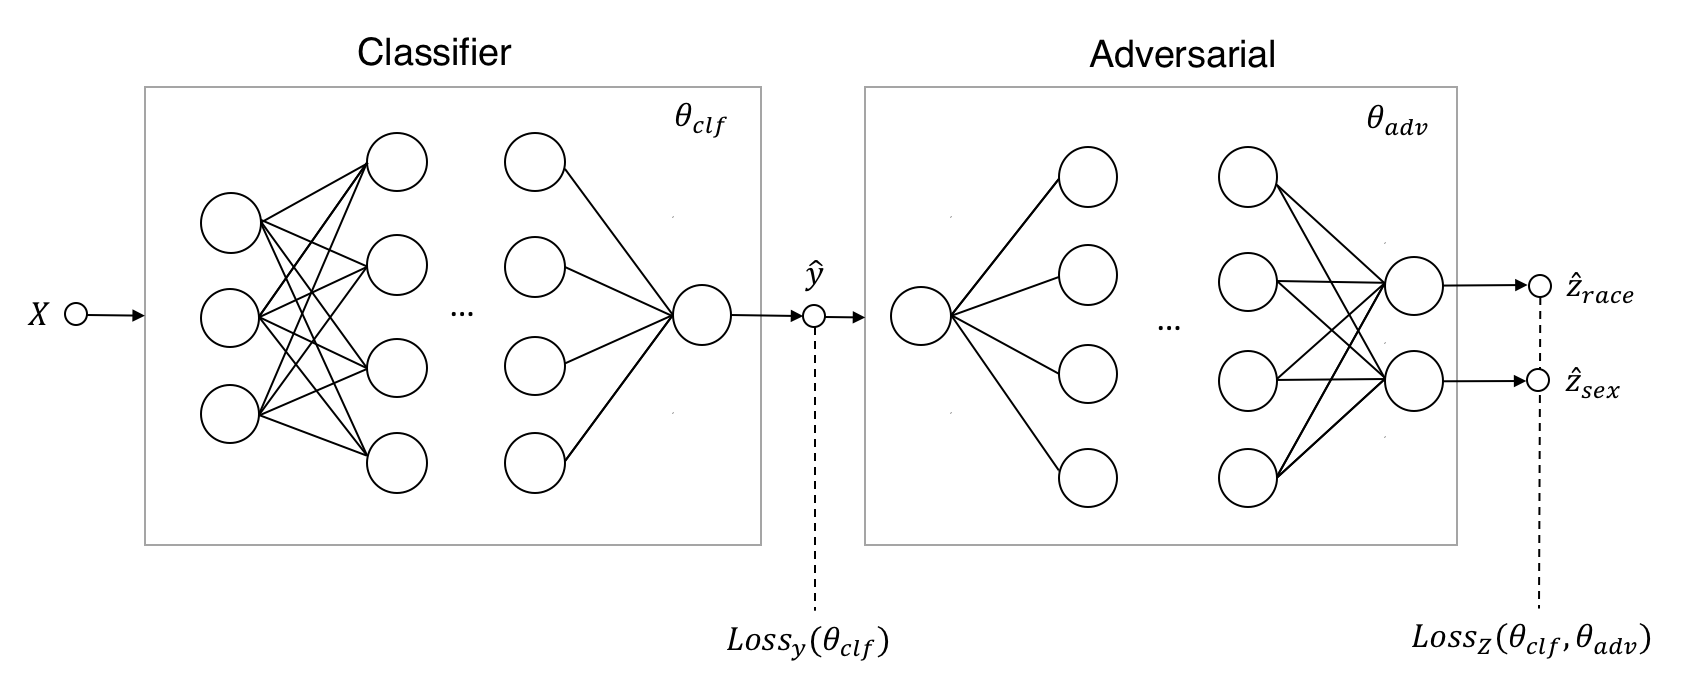

The subsequent section begins by utilizing PyTorch utilities to load the dataset. Then, proceed to define and pre-train the classifier and adversarial components separately. These individual components are subsequently combined and trained collectively to yield a fair classifier.

# Data

Our objective is to make income level predictions using personal attributes like age, education, and marital status. However, we face a challenge where our conventional classifier exhibits unfairness towards black individuals and women. For instance, women may receive lower income predictions compared to men, despite gender not being a part of the personal attributes. Such biases can arise from dataset-specific or real-world factors, but we aim to prevent these biases from influencing unfair predictions.

In [ ]:
''' X_train, X_test: attributes used for prediction - like age and native country
    y_train, y_test: target we want to predict - if someone makes more than 50K
    Z_train, Z_test: sensitive attributes - race and color. '''


# load ICU data set
X, y, Z = load_ICU_data('adult.data')
n_features = X.shape[1]
n_sensitive = Z.shape[1]

# split into train/test set
(X_train, X_test, y_train, y_test, Z_train, Z_test) = train_test_split(X, y, Z, test_size=0.3, stratify=y, random_state=10)


# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), 
                                           columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler) 

features X: 30940 samples, 93 attributes
targets y: (30940,) samples
sensitives Z: 30940 samples, 2 attributes


We have the datset as a pandas DataFrame. PyTorch has some tools to make data loading and sampling easier. Here, you should use the "Dataset" and "DataLoader".  A "Dataset" generally takes and returns PyTorch tensors, not rows from a pandas DataFrame. Add some logic to the TensorDataset that converts DataFrames into tensors. Subclass the TensorDataset so you can initialize a Dataset with your pandas DataFrames.

In [ ]:
class PandasDataSet(TensorDataset):

  def __init__(self, *dataframes):
      tensors = (self._df_to_tensor(df) for df in dataframes)
      super(PandasDataSet, self).__init__(*tensors)

  def _df_to_tensor(self, df):
      if isinstance(df, pd.Series):
          df = df.to_frame('dummy')
      return torch.from_numpy(df.values).float()


train_data = PandasDataSet(X_train, y_train, Z_train)
test_data = PandasDataSet(X_test, y_test, Z_test)

Create a DataLoader that returns shuffled batches of your training set:

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)

print('# training samples:', len(train_data))
print('# batches:', len(train_loader))

# training samples: 21658
# batches: 676


# Income predictions

Define and pre-train a classifier to predict income levels. While this classifier may perform well in predicting income, there is a risk that it could be unfair. Its training is focused solely on maximizing performance, without taking fairness into account.

In [ ]:
class Classifier(nn.Module):

    def __init__(self, n_features, n_hidden=32, p_dropout=0.2):
        super(Classifier, self).__init__()
        
        ''' Utilize a four-layer MLP with ReLU activation and
         Dropout after each Linear layer, except for the last one.'''

        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, 1),)

    def forward(self, x):
        return torch.sigmoid(self.network(x))

Initialize the classifier and select binary cross-entropy as the loss function. Then, use the Adam optimizer to optimize the weights of the classifier.

In [ ]:
clf = Classifier(n_features=n_features)
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())

Time to pretrain the classifier! For each epoch, you should iterate over the batches returned by your DataLoader.



In [ ]:
def pretrain_classifier(clf, data_loader, optimizer, criterion):
    for x, y, _ in data_loader:
        clf.zero_grad()
        p_y = clf(x)
        loss = criterion(p_y, y)
        loss.backward()
        optimizer.step()
    return clf


for epoch in range(2):
    clf = pretrain_classifier(clf, train_loader, clf_optimizer, clf_criterion)

# Detecting unfairness

With the pre-trained classifier in place, let's proceed to define and pre-train the adversary. Just like the classifier, your adversary will comprise four layers. However, in this case, the input will be sourced from a single class, which is the predicted income class, while the output will encompass two sensitive classes, namely sex and race.

In [ ]:
class Adversary(nn.Module):

    def __init__(self, n_sensitive, n_hidden=32):
        super(Adversary, self).__init__()
        
        '''Utilize a four-layer MLP with ReLU activation 
        after each Linear layer, except for the last one.'''
        
        self.network = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_sensitive),
        )

    def forward(self, x):
        return torch.sigmoid(self.network(x))


There will be a trade-off between classifier performance and fairness concerning your sensitive attributes. To address this, you can adjust the adversarial loss to incorporate the trade-off by introducing a lambda parameter that weighs the adversarial loss for each class. This lambda parameter is then utilized to scale the performance of the adversary in relation to the performance of the classifier.

In [ ]:
lambdas = torch.Tensor([130, 30])
adv = Adversary(Z_train.shape[1])
adv_criterion = nn.BCELoss(reduce=False)
adv_optimizer = optim.Adam(adv.parameters())

By instructing nn.BCELoss to not perform reduction, you obtain the losses for each individual sample and class rather than a single number. By multiplying these losses with your lambdas and calculating their average, you obtain the weighted adversarial loss, which serves as our measure of unfairness.

Training the adversary closely resembles the process of training the classifier.

In [ ]:
def pretrain_adversary(adv, clf, data_loader, optimizer, criterion):
    for x, _, z in data_loader:
        p_y = clf(x).detach()
        adv.zero_grad()
        p_z = adv(p_y)
        loss = (criterion(p_z, z) * lambdas).mean()
        loss.backward()
        optimizer.step()
    return adv


for epoch in range(5):
    pretrain_adversary(adv, clf, train_loader, adv_optimizer, adv_criterion)

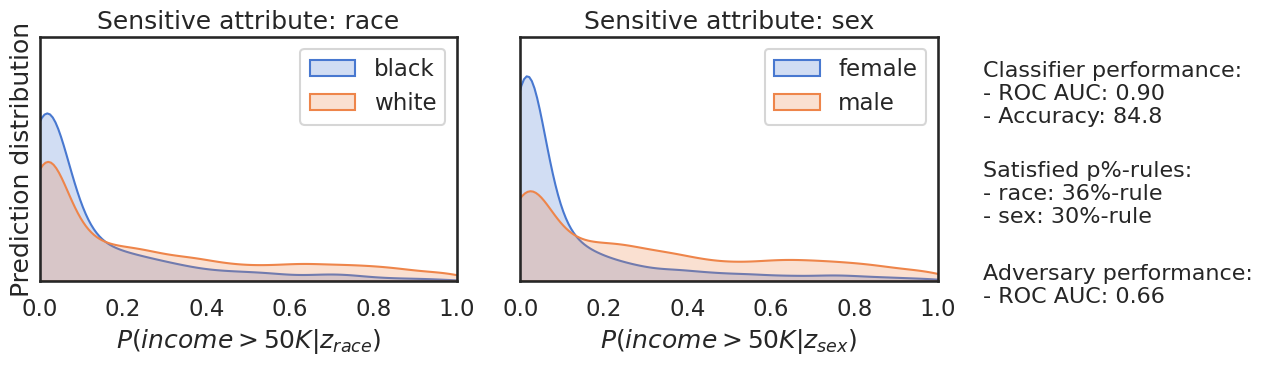

In [ ]:
with torch.no_grad():
    pre_clf_test = clf(test_data.tensors[0])
    pre_adv_test = adv(pre_clf_test)


y_pre_clf = pd.Series(pre_clf_test.data.numpy().ravel(),
                      index=y_test.index)
y_pre_adv = pd.DataFrame(pre_adv_test.numpy(), columns=Z.columns)
fig = plot_distributions(y_test, Z_test, y_pre_clf, y_pre_adv)

Unfortunately, the classifier lacks fairness. This can be observed from both the p%-rule and distributions of probabilities, as well as the ROC AUC score of the adversary. If the score exceeds 0.5, it signifies the adversary's ability to detect unfairness.

# Training for fairness

Now that you have an unfair classifier and an adversary that is able to pick up on unfairness, engage them in the zero-sum game to make the classifier fair. Remember that the fair classifier will be punished according to:


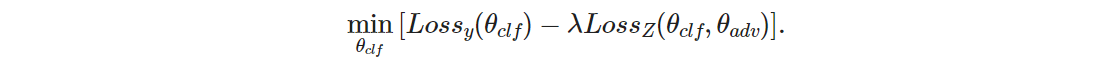

The first term represents how good the classifier is in predicting income, the second how good the adversary can reconstruct unfairness. The parameter 
 represents the trade-off between these terms: it weighs the punishment by the adversary versus the prediction performance.

The adversary learns on the full data set and the classifier is given only the single batch, giving the adversary a slight edge in learning. The loss function for the classifier is changed to its original loss plus the weighted negative adversarial loss.

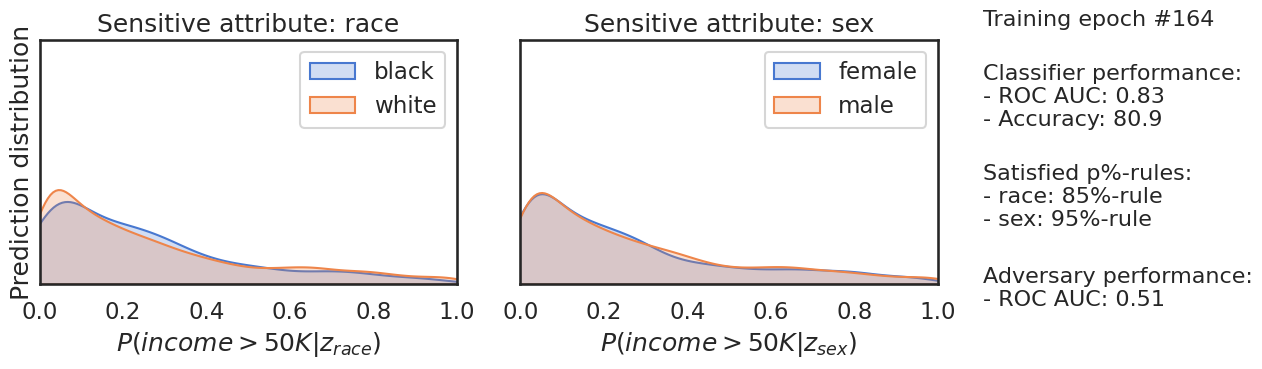

In [ ]:
def train(clf, adv, data_loader, clf_criterion, adv_criterion,
          clf_optimizer, adv_optimizer, lambdas):
    
    # Train adversary
    for x, y, z in data_loader:
        p_y = clf(x)
        adv.zero_grad()
        p_z = adv(p_y)
        loss_adv = (adv_criterion(p_z, z) * lambdas).mean()
        loss_adv.backward()
        adv_optimizer.step()
 
    # Train classifier on single batch
    for x, y, z in data_loader:
        pass
    p_y = clf(x)
    p_z = adv(p_y)
    clf.zero_grad()
    p_z = adv(p_y)
    loss_adv = (adv_criterion(p_z, z) * lambdas).mean()
    clf_loss = clf_criterion(p_y, y) - (adv_criterion(adv(p_y), z) * lambdas).mean()
    clf_loss.backward()
    clf_optimizer.step()
    
    return clf, adv



for epoch in range(1, 165):
    
    clf, adv = train(clf, adv, train_loader, clf_criterion, adv_criterion, clf_optimizer, adv_optimizer, lambdas)

    with torch.no_grad():
        clf_pred = clf(test_data.tensors[0])
        adv_pred = adv(clf_pred)

    y_post_clf = pd.Series(clf_pred.numpy().ravel(), index=y_test.index)
    Z_post_adv = pd.DataFrame(adv_pred.numpy(), columns=Z_test.columns)
    
    fig = plot_distributions(y_test, Z_test, y_post_clf, Z_post_adv, epoch)
    display.clear_output(wait=True)
    plt.show(plt.gcf())

# Resource
https://github.com/equialgo/fairness-in-ml/blob/master/fairness-in-torch.ipynb